# tmp — may24

**Motivation**: scratch notebook <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-vae/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-vae/figs')
tmp_dir = os.path.join(git_dir, 'jb-vae/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_PoissonVAE'))
from figures.fighelper import *
from vae.train_vae import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

In [2]:
device_idx = 3
device = f'cuda:{device_idx}'

In [3]:
root = add_home('Dropbox/chkpts/PoissonVAE')

models2load = {
    'poisson': 'poisson-<lin|lin>-DOVES-mc_mach-5_(2024_05_14,04:46)',
    'categorical': 'categorical-<lin|lin>-DOVES-mc_mach-5_(2024_05_14,04:04)',
    'gaussian': 'gaussian-<lin|lin>-DOVES-mc_mach-5_(2024_05_14,04:09)',
    'laplace': 'laplace-<lin|lin>-DOVES-mc_mach-5_(2024_05_14,04:12)',
}
models2load = {k: v.replace('/', ':') for k, v in models2load.items()}

In [4]:
trainers = {}
for name, load_path in models2load.items():
    try:
        trainers[name], _ = load_quick(
            pjoin(root, load_path),
            lite=True,
            device=device,
            verbose=True,
        )
    except FileNotFoundError:
        continue

# params: 262.7 K

# params: 262.7 K

# params: 394.2 K

# params: 394.2 K

In [8]:
tr = trainers['poisson']
data, loss, etc = tr.validate()

order = np.argsort(loss['kl_diag'])

In [ ]:
mse = []

In [ ]:
def forward_modified(
        self,
        dl_name: str,
        temp: float = None,
        use_ema: bool = False,
        knock_out: Sequence[int] = None,
        knock_out_val: float = 0.0,
        full_data: bool = False, ):
    assert dl_name in ['trn', 'vld', 'tst']
    dl = getattr(self, f"dl_{dl_name}")
    if dl is None:
        return
    model = self.select_model(use_ema)
    if temp is None:
        temp = model.temp

    mse, kl, kl_diag = [], [], []
    x_all, y_all, z_all, g_all = [], [], [], []
    etc = collections.defaultdict(list)

    for x in iter(dl):
        if len(x) == 2:
            x, g = x
        else:
            g = None
        if isinstance(x, (tuple, list)):
            x = x[0]
        if x.device != self.device:
            x = self.to(x)
        if self.model.cfg.type == 'poisson':
            dist, log_dr, z, y = model.xtract_ftr(x, temp)
            _kl = model.loss_kl(log_dr)
            etc['log_dr'].append(tonp(log_dr))
            etc['r*dr'].append(tonp(dist.rate))
        elif self.model.cfg.type in [
                'gaussian', 'laplace', 'categorical']:
            dist, z, y = model.xtract_ftr(x, temp)
            _kl = model.loss_kl(dist)
            if self.model.cfg.type == 'categorical':
                etc['logits'].append(tonp(dist.logits))
            else:
                etc['loc'].append(tonp(dist.loc))
                etc['scale'].append(tonp(dist.scale))
        else:
            raise ValueError(self.model.cfg.type)
        # data
        if full_data or dl_name == 'trn':
            x_all.append(tonp(x))
            y_all.append(tonp(y))
            if g is not None:
                g_all.append(tonp(g))
        z_all.append(tonp(z))
        # loss
        mse.append(tonp(model.loss_recon(y, x)))
        kl.append(tonp(torch.sum(_kl, dim=1)))
        kl_diag.append(tonp(torch.mean(
            _kl, dim=0, keepdim=True)))

    x, y, z, g, mse, kl, kl_diag = cat_map(
        [x_all, y_all, z_all, g_all, mse, kl, kl_diag])
    data = {'x': x, 'y': y, 'z': z, 'g': g}
    loss = {'mse': mse, 'kl': kl, 'kl_diag': kl_diag.mean(0)}
    etc = {k: np.concatenate(v) for k, v in etc.items()}
    return data, loss, etc

In [3]:
cfg_vae, cfg_tr = default_configs('MNIST', model_type, 'lin|lin')
cfg_tr['method'] = 'exact'
cfg_vae['seed'] = 2990

vae = MODEL_CLASSES[model_type](CFG_CLASSES[model_type](**cfg_vae))
tr = TrainerVAE(vae, ConfigTrainVAE(**cfg_tr), device=device)

In [4]:
x, *_ = next(iter(tr.dl_trn))

In [5]:
mse, dist, _ = vae.loss_recon_exact(x)

In [6]:
mse.shape

torch.Size([200])

In [5]:
dist = vae.infer(x[:3], t=1e-8)

In [6]:
from base.distributions import Categorical

rng = get_rng()
probs = rng.gamma(2, 1, size=(200, 10))
probs = probs / probs.max()
probs /= probs.sum(-1, keepdims=True)
dist = Categorical(logits=torch.logit(torch.tensor(probs)), temp=0)

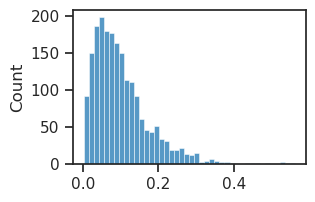

In [7]:
sns.histplot(tonp(dist.probs.ravel()))
plt.show()

In [8]:
samples = dist.sample((100000,))

In [9]:
mu, var = samples.mean(0), samples.var(0)

In [13]:
torch.round(mu - dist.mean, decimals=2)

tensor([[0., 0., -0.,  ..., 0., -0., 0.],
        [-0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., -0.,  ..., 0., -0., 0.],
        ...,
        [-0., 0., 0.,  ..., -0., 0., -0.],
        [-0., 0., -0.,  ..., -0., -0., -0.],
        [0., -0., 0.,  ..., -0., -0., 0.]], dtype=torch.float64)

In [12]:
torch.round(var - dist.variance, decimals=2)

tensor([[0., 0., -0.,  ..., 0., -0., 0.],
        [-0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., -0.,  ..., 0., -0., 0.],
        ...,
        [-0., 0., 0.,  ..., -0., 0., -0.],
        [-0., 0., -0.,  ..., -0., -0., -0.],
        [0., -0., 0.,  ..., -0., -0., 0.]], dtype=torch.float64)

In [11]:
var[b, 0, c], variance[b, 0, c]

(tensor(0.0021, device='cuda:3'),
 tensor(0.0021, device='cuda:3', grad_fn=<SelectBackward0>))

In [15]:
torch.round(var - variance, decimals=3)

tensor([[[-0., 0., -0.,  ..., -0., -0., 0.]],

        [[0., -0., 0.,  ..., -0., -0., 0.]],

        [[0., 0., -0.,  ..., -0., 0., -0.]]], device='cuda:3',
       grad_fn=<RoundBackward1>)

In [5]:
mse, dist, _ = vae.loss_recon_exact(x)

NotImplementedError: 

In [9]:
dist.mean

NotImplementedError: 

In [10]:
dist.probs.shape

torch.Size([200, 1, 512])

In [12]:
samples = dist.sample((10000, ))
samples.shape

torch.Size([10000, 200, 1, 512])

/home/hadi/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Count'>

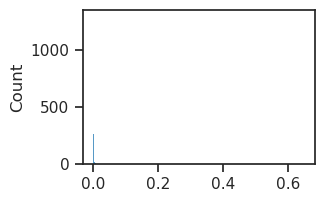

In [13]:


sns.histplot(tonp(samples[:, b, 0, c]))

In [14]:
mu, sd = samples.mean(0), samples.std(0)

In [16]:
mu[b, 0, c], dist.probs[b, 0, c]

(tensor(0.0018, device='cuda:3'),
 tensor(0.0017, device='cuda:3', grad_fn=<SelectBackward0>))

In [ ]:
tr.train()

epoch # 74, avg loss: 76.134607:   6%|▍       | 74/1200 [04:15<56:44,  3.02s/it]

In [3]:
print(torch.cuda.is_available())
print(f"torch: {torch.__version__}\tcuda: {torch.version.cuda}\tcudnn: {torch.backends.cudnn.version()}")
print()

True

torch: 2.3.0    cuda: 12.1      cudnn: 8902

In [4]:
torch.backends.cudnn.benchmark = True

In [5]:
import torch
from torch import nn
x = nn.Parameter(torch.randn(123, 16, 64, 64), requires_grad=True).cuda()
conv = nn.Conv2d(16, 32, 3, 1).cuda()
y = conv(x)
loss = (y - 1).pow(2).sum()
loss.backward()

In [ ]:
# torch.backends.cudnn.deterministic = True

In [5]:
cfg_vae, cfg_tr = default_configs('MNIST', model_type, 'conv+b|lin')
vae = MODEL_CLASSES[model_type](CFG_CLASSES[model_type](**cfg_vae))
tr = TrainerVAE(vae, ConfigTrainVAE(**cfg_tr), device=device)

In [ ]:
tr.train()

epoch # 956, avg loss: 40.660207:  80%|█████████████████▌    | 956/1200 [4:21:21<1:03:34, 15.63s/it]

epoch # 20, avg loss: 129.306015:   2%|▍                        | 20/1200 [03:30<3:51:05, 11.75s/it]

In [5]:
### Was: mach

  0%|                                                                      | 0/1200 [00:00<?, ?it/s]/home/hadi/Dropbox/git/_PoissonVAE/base/common.py:353: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /opt/conda/conda-bld/pytorch_1712608853085/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(
/home/hadi/anaconda3/lib/python3.11/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /opt/conda/conda-bld/pytorch_1712608853085/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
epoch # 4, avg loss: 53.324352:   0%|                            | 4/1200 [01:19<6:

KeyboardInterrupt: 

In [5]:
### Was: solo

epoch # 5, avg loss: 53.524626:   0%|                            | 5/1200 [01:02<4:07:08, 12.41s/it]


KeyboardInterrupt: 

In [3]:
conv_no_warn = nn.Conv2d(8, 3, kernel_size=3, stride=1, padding=0).eval().cuda()
conv_warn = nn.Conv2d(8, 1, kernel_size=3, stride=1, padding=0).eval().cuda()
x = torch.rand((1, 8, 546, 392)).cuda()

with torch.inference_mode(), torch.autocast(device_type="cuda"):
    # No warning
    conv_no_warn(x)
    # UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED
    conv_warn(x)

In [4]:
print(torch.cuda.is_available())
print(f"torch: {torch.__version__}\tcuda: {torch.version.cuda}\tcudnn: {torch.backends.cudnn.version()}")
print()

True

torch: 2.3.0    cuda: 11.8      cudnn: 8700

In [5]:
torch.backends.cudnn.enabled = True
torch.backends.cudnn.enabled

True

In [6]:
import torch
from torch import nn
x = nn.Parameter(torch.randn(123, 16, 64, 64), requires_grad=True).cuda()
conv = nn.Conv2d(16, 32, 3, 1).cuda()
y = conv(x)
loss = (y - 1).pow(2).sum()
loss.backward()

In [7]:
cfg_vae, cfg_tr = default_configs('MNIST', model_type, 'conv+b|conv+b')
print(f"VAE:\n{cfg_vae}\n\nTrainer:\n{cfg_tr}")

VAE:
{'dataset': 'MNIST', 'n_ch': 32, 'n_latents': 10, 'prior_clamp': -2, 'fit_prior': True, 'enc_type': 'conv', 
'dec_type': 'conv', 'enc_bias': True, 'dec_bias': True, 'init_dist': 'StudentT', 'init_scale': 0.1}

Trainer:
{'lr': 0.002, 'epochs': 1200, 'batch_size': 200, 'warm_restart': 2, 'optimizer_kws': {'weight_decay': 0.0003}, 
'grad_clip': 1000, 'kl_const_portion': 0.01}

+-------------+------------+
| Module Name | Num Params |
+-------------+------------+
|  PoissonVAE |  6.2 Mil   |
|     ---     |    ---     |
|     stem    |    352     |
|     enc     |  4.9 Mil   |
|    fc_enc   |   2.6 K    |
|    fc_dec   |   11.3 K   |
|     dec     |  1.2 Mil   |
+-------------+------------+

poisson_uniform_c(-2)_MNIST_z-10_k-32_fp_<conv+b|conv+b>
mc_b200-ep1200-lr(0.002)_beta(1:0x0.5)_temp(0.05:lin-0.5)_gr(1000)_(2024_05_09,03:23)

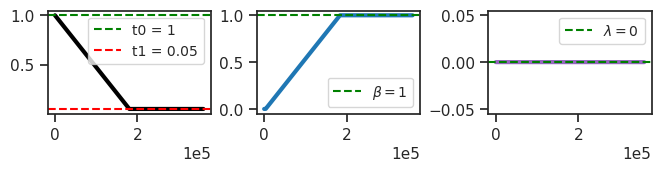

In [8]:
vae = MODEL_CLASSES[model_type](CFG_CLASSES[model_type](**cfg_vae))
tr = TrainerVAE(vae, ConfigTrainVAE(**cfg_tr), device=device)

vae.print()
print(f"{vae.cfg.name()}\n{tr.cfg.name()}_({vae.timestamp})\n")
tr.show_schedules()

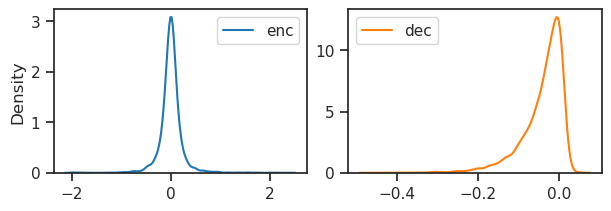

In [9]:
fig, axes = create_figure(1, 2)
sns.kdeplot(tonp(vae.fc_enc.weight.data.ravel()), label='enc', color='C0', ax=axes[0])
sns.kdeplot(tonp(vae.fc_dec.weight.data.ravel()), label='dec', color='C1', ax=axes[1])
axes[1].set_ylabel('')
add_legend(axes)
plt.show()

In [ ]:
comment = f"testing_{tr.cfg.name()}"
# comment = tr.cfg.name()
tr.train(comment=comment)

epoch # 36, avg loss: 85.353015:   3%|▊                         | 36/1200 [11:33<6:00:35, 18.59s/it]

In [ ]:
tr.show_recon(0.0), tr.show_samples(0.0);

In [12]:
tr.dl_vld.dataset.tensors

(tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         ...,
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ..

In [13]:
data, loss, etc = tr.validate()

_loss = {k: v.mean() for k, v in loss.items()}
_loss['tot'] = _loss['mse'] + _loss['kl']
print(_loss)

{'mse': 31.922916, 'kl': 65.528015, 'kl_diag': 6.5528016, 'tot': 97.45093}

In [ ]:
df, df_summary = knn_analysis(
    x=etc['log_dr'],
    y=tonp(tr.dl_vld.dataset.tensors[1]),
    n_iter=100,
    verbose=True,
)

In [ ]:
df_summary